<a href="https://colab.research.google.com/github/Meenakshivinaysyal/MySqlUsingPython/blob/main/item_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Name : Meenakshi Kumari 
 Batch : D10     
 Project : Item Demand Forecasting model

In [ ]:
import numpy as np    #   NumPy library into your current environment for mathematical operations.
import pandas as pd    # for data manipulation and analysis
import matplotlib.pyplot as plt  #  matplotlib.pyplot is a plotting library used for 2D graphics
import seaborn as sns           # data visualization and exploratory data analysis
#import plotly.graph_objs as go
#import plotly.offline as py

from dateutil.relativedelta import relativedelta      # applied to an existing datetime and can replace specific components of that datetime, or represents an interval of time.
from scipy.optimize import minimize                   # to find the minimum of scalar functions of one or more variables. 
import statsmodels.api as sm

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import warnings

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
proj_train = pd.read_csv('/content/train.csv', index_col = 0)      # load .csv file ,take first column as index 
proj_train.index = pd.to_datetime(proj_train.index)                 # convert index as date
display(proj_train.sample(10))                                     # display 10 samples data here


,store,item,sales
date,,,
2013-06-21,7,9,24
2015-08-30,3,29,100
2014-11-09,8,23,40
2013-10-12,1,45,72
2015-03-06,6,40,19
2016-01-31,3,29,53
2016-06-02,2,6,113
2014-01-22,2,25,68
2014-04-27,3,13,108


In [ ]:
display(proj_train.info())              # displays information  about the DataFrame.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


None

***we do not have any missing value here ***

In [ ]:
display(proj_train.describe())                                                  #The describe() method computes and displays summary statistics for a Python dataframe.

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


**First We Visualise the Sales on  day basis and see thw total items sale each day**

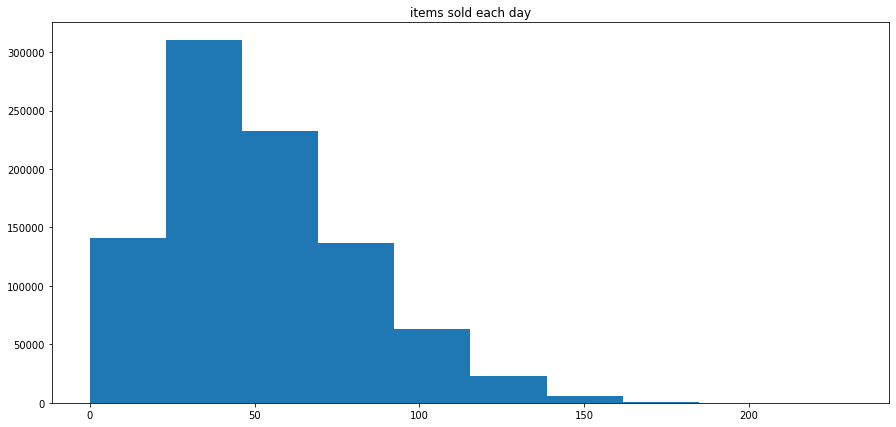

In [ ]:
# to visualise  the total items sold out each day 
plt.figure(figsize = (15,7))
plt.hist(proj_train['sales'], bins = 10)
plt.title('items sold each day')
plt.show()

# now here we filter out some data ,take some data from store and some from item

In [ ]:
inventory_df = proj_train.copy()
store_id = 10   #  store data
item_id = 40    # item data 
print('Before filter:', inventory_df.shape)

Before filter: (913000, 3)


In [ ]:
inventory_df = inventory_df[inventory_df.store == store_id]
inventory_df = inventory_df[inventory_df.item == item_id]
print('After filter:', inventory_df.shape)

After filter: (1826, 3)


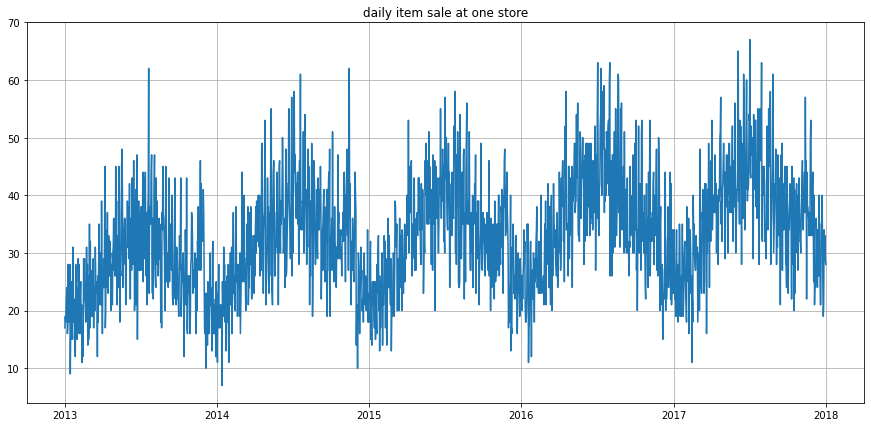

In [ ]:
# display store and item head info
plt.figure(figsize = (15,7))
plt.plot(inventory_df.index, inventory_df.sales)
plt.grid(True)
plt.title('daily item sale at one store')
plt.show()

***The daily sales values seem very sporadic, we are now gonna plot the sum value of item sales over a week***

sales                          ...                              
item          1     2     3     4     5   ...    46    47    48    49    50
date                                      ...                              
2013-05-19  1454  3815  2436  1414  1217  ...  3859  1483  3332  1961  4440
2014-03-30  1500  4017  2414  1537  1308  ...  4035  1491  3561  1991  4540
2013-03-03  1182  3105  1915  1175   945  ...  3083  1178  2750  1560  3556
2015-12-13  1119  3098  1940  1142   941  ...  3170  1171  2724  1582  3388
2013-03-31  1422  3580  2276  1362  1106  ...  3627  1315  3120  1874  4127
2013-11-10  1321  3710  2196  1396  1099  ...  3626  1341  3180  1820  3953
2016-06-19  2140  5276  3313  2088  1659  ...  5539  1979  4635  2662  6156
2013-05-26  1470  3982  2514  1502  1275  ...  3980  1453  3456  1933  4381
2016-01-31  1274  3419  2055  1325  1063  ...  3277  1256  2936  1718  3752
2015-05-24  1717  4686  2867  1799  1393  ...  4681  1787  4189  2277  5230

[10 rows x 50 columns]

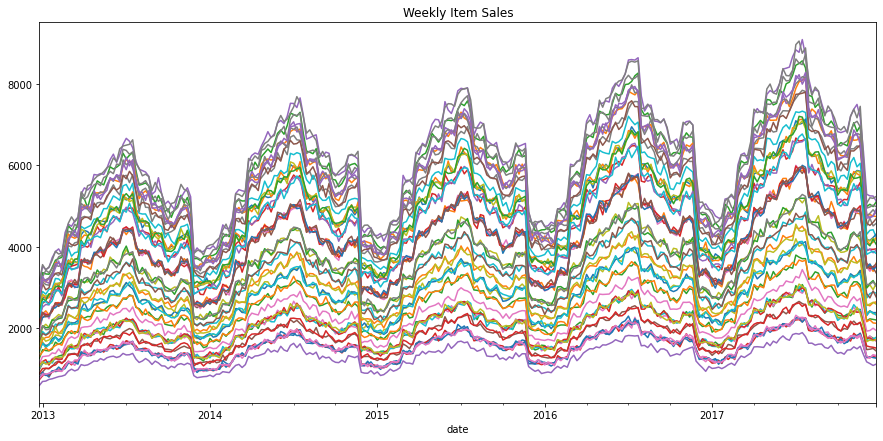

In [ ]:
stores_sales_df = proj_train.copy()
stores = pd.DataFrame(stores_sales_df.groupby(['date', 'item']).sum()['sales']).unstack()
stores = stores.resample('W',label='left').sum()
stores.sort_index(inplace = True)

display(stores.sample(10))

stores.plot(figsize=(15,7), title='Weekly Item Sales', legend=None)
plt.show()

***The daily sales values seem very sporadic, we are now gonna plot the sum value of store sales over a week***

sales                       ...                            
store          1      2      3      4   ...     7      8      9      10
date                                    ...                            
2015-02-08  12596  17586  15993  14626  ...   9453  16924  14502  15378
2013-12-08  10419  14679  13048  11884  ...   8028  14123  12289  13001
2013-08-11  15834  21992  19847  18089  ...  12151  21016  18069  19370
2013-11-17  14481  20656  18253  17031  ...  11145  19850  17045  18005
2016-06-05  21810  30542  27120  25150  ...  16790  29523  25472  26866
2017-07-02  24060  33644  29951  27571  ...  18248  32009  27591  29517
2016-08-14  20191  28621  25573  23672  ...  15305  27934  23583  25393
2013-06-02  16500  23555  20975  19101  ...  12764  22477  19338  20655
2013-09-29  13466  19310  17290  15713  ...  10563  18680  15797  16822
2014-09-07  16780  23883  21125  19486  ...  12793  22611  19481  21027

[10 rows x 10 columns]

sales                                                              
store          1      2      3      4      5      6     7      8      9      10
date                                                                           
2012-12-30   8449  11713  10345   9650   6836   7117  6238  11107   9421  10191
2013-01-06   9289  13451  11869  10886   7884   7917  7273  12787  10887  11659
2013-01-13   9287  13264  11660  10760   7851   7894  7120  12791  10753  11570
2013-01-20   9229  13329  11888  10747   7822   7932  7277  12606  10922  11546
2013-01-27   9826  14058  12429  11585   8267   8305  7471  13346  11422  12318
2013-02-03  10281  14771  13005  12205   8574   8705  7932  14284  12005  12804
2013-02-10  10337  14941  13127  12177   8816   8722  7987  14085  12172  12897
2013-02-17  10425  14783  12976  12171   8750   8653  7983  13912  12010  13103
2013-02-24  11306  16266  14160  13371   9617   9688  8730  15507  13135  14036
2013-03-03  12614  17674  15759  14193  10492  10541  9548  16892  14433  15559

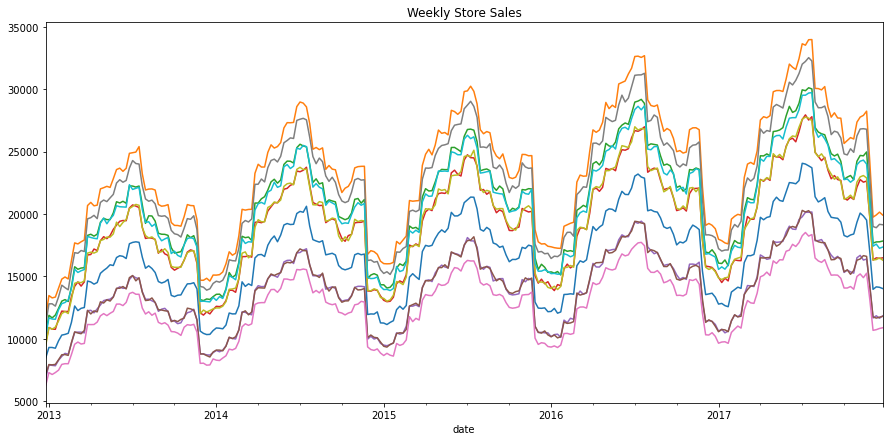

In [ ]:
stores_sales_df1 = proj_train.copy()
stores = pd.DataFrame(stores_sales_df1.groupby(['date', 'store']).sum()['sales']).unstack()
stores = stores.resample('W',label='left').sum()
stores.sort_index(inplace = True)

display(stores.sample(10))
display(stores.head(10))

stores.plot(figsize=(15,7), title='Weekly Store Sales', legend=None)
plt.show()

***visualise the trends, seasonality and other features (on both additive and multiplicative scales) here.***

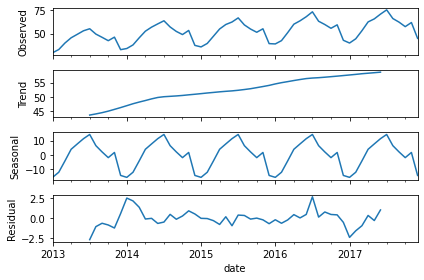

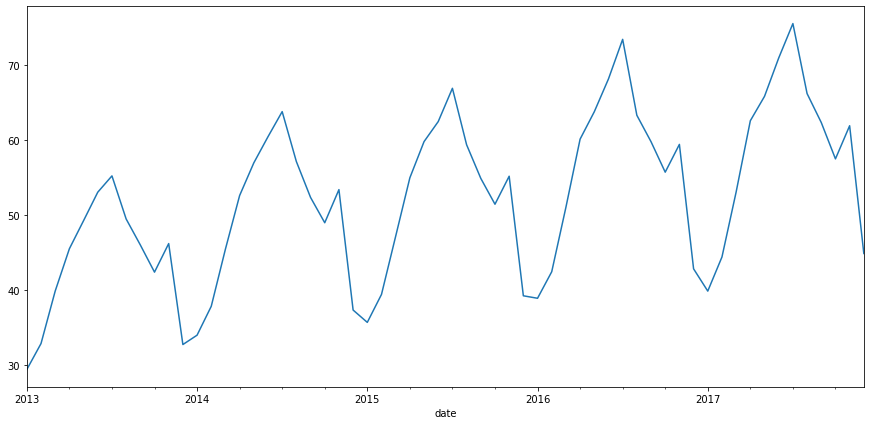

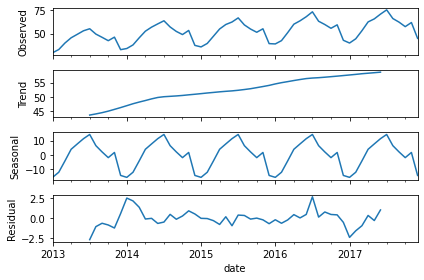

In [ ]:
date_sales = proj_train.drop(['store','item'], axis=1).copy() 
y = date_sales['sales'].resample('MS').mean() 
y['2017':] # see sneak peak 
y.plot(figsize=(15, 7))

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()

# Still have to make sense of the plots and describe it, also, need to try and plot these components on a weekly basis, but on a smaller time scale as 

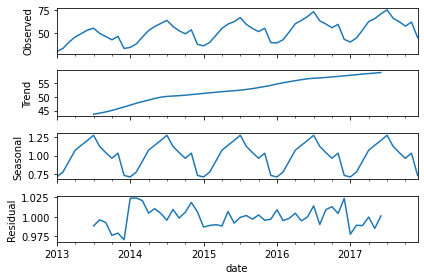

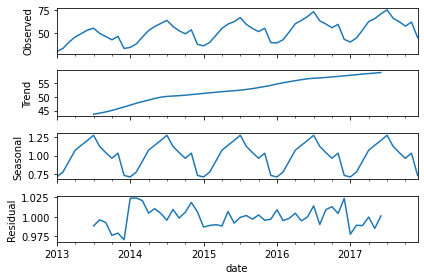

In [ ]:
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition.plot()

********************************************************************************
**Regression Part**

This part is divided into

**Feature Generation**
Model Training
Ploting Results
**1) Feature Generation**
We are gonna try out the following three things

**Lags of time series itself**
Adding Window Statistics (Max/Min/Mean/Variance of window)
Day of the week, Day of the month, Day of the quarter, is it a holiday, did something special happen this day, etc.


In [ ]:
from datetime import date       # Datetime module supplies classes to work with date and time.
import holidays

In_holidays = holidays.India()

# For Holidays pip install holidays we have 

In [ ]:
store_sale_train = pd.read_csv('/content/train.csv')
storewise_train = store_sale_train.set_index(['store', 'item', 'date'])
store_id = 10     #Random store id
item_id = 40      # Random item id
store_item_sale_TS = create_data(storewise_train, store_id, item_id)
store_item_sale_TS_train= store_item_sale_TS.iloc[:-180]
store_item_sale_TS_test = store_item_sale_TS.iloc[-180:]
store_item_sale_df_not_TS = store_item_sale_TS.reset_index()

In [ ]:
store_item_sale_TS_0 = store_item_sale_TS.copy()
store_item_sale_TS_0['day_of_year'] = 0
store_item_sale_TS_0['week_of_year'] = 0
store_item_sale_TS_0['month_of_year'] = 0
store_item_sale_TS_0['day_of_month'] = 0
store_item_sale_TS_0['day_of_week'] = 0
store_item_sale_TS_0['weekend'] = 0
store_item_sale_TS_0['holiday'] = 0

for date in store_item_sale_TS_0.index:
    store_item_sale_TS_0.loc[date, 'day_of_year'] = date.dayofyear
    store_item_sale_TS_0.loc[date, 'week_of_year'] = date.weekofyear
    store_item_sale_TS_0.loc[date, 'month_of_year'] = date.month
    store_item_sale_TS_0.loc[date, 'day_of_month'] = date.day
    store_item_sale_TS_0.loc[date, 'day_of_week'] = date.dayofweek
    if date in In_holidays:
        store_item_sale_TS_0.loc[date,'holiday'] = 1
    if date.dayofweek == 6 or date.dayofweek == 5:
        store_item_sale_TS_0.loc[date,'weekend'] = 1
    
display(store_item_sale_TS_0.head())
#  added date related features here

,sales,day_of_year,week_of_year,month_of_year,day_of_month,day_of_week,weekend,holiday
date,,,,,,,,
2013-01-01,17,1,1,1,1,1,0,0
2013-01-02,19,2,1,1,2,2,0,0
2013-01-03,18,3,1,1,3,3,0,0
2013-01-04,21,4,1,1,4,4,0,0
2013-01-05,23,5,1,1,5,5,1,0


In [ ]:
store_item_sale_TS_1 = store_item_sale_TS_0.copy()
for i in range(365,365+28):
    store_item_sale_TS_1["lag_{}".format(i)] = store_item_sale_TS_1.sales.shift(i)
display(store_item_sale_TS_1.head())
display(store_item_sale_TS_1.tail())

# code to add lag features here

,sales,day_of_year,week_of_year,month_of_year,day_of_month,day_of_week,weekend,holiday,lag_365,lag_366,lag_367,lag_368,lag_369,lag_370,lag_371,lag_372,lag_373,lag_374,lag_375,lag_376,lag_377,lag_378,lag_379,lag_380,lag_381,lag_382,lag_383,lag_384,lag_385,lag_386,lag_387,lag_388,lag_389,lag_390,lag_391,lag_392
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,17,1,1,1,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,19,2,1,1,2,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,18,3,1,1,3,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,21,4,1,1,4,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,23,5,1,1,5,5,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,sales,day_of_year,week_of_year,month_of_year,day_of_month,day_of_week,weekend,holiday,lag_365,lag_366,lag_367,lag_368,lag_369,lag_370,lag_371,lag_372,lag_373,lag_374,lag_375,lag_376,lag_377,lag_378,lag_379,lag_380,lag_381,lag_382,lag_383,lag_384,lag_385,lag_386,lag_387,lag_388,lag_389,lag_390,lag_391,lag_392
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-27,34,361,52,12,27,2,0,0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0,21.0,38.0
2017-12-28,30,362,52,12,28,3,0,0,23.0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0,21.0
2017-12-29,33,363,52,12,29,4,0,0,34.0,23.0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0
2017-12-30,29,364,52,12,30,5,1,0,23.0,34.0,23.0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0
2017-12-31,28,365,52,12,31,6,1,0,30.0,23.0,34.0,23.0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0


In [ ]:
month_lag_colname_list = ["lag_{}".format(i + 365) for i in range(0,28)]
week1_lag_colname_list = ["lag_{}".format(i + 365) for i in range(0,7)]
week2_lag_colname_list = ["lag_{}".format(i + 365) for i in range(7,14)]
week3_lag_colname_list = ["lag_{}".format(i + 365) for i in range(14,21)]
week4_lag_colname_list = ["lag_{}".format(i + 365) for i in range(21,28)]
fortnight_lag_colname_list = ["lag_{}".format(i + 365) for i in range(0,14)]

store_item_sale_TS_2 = store_item_sale_TS_1.copy()

store_item_sale_TS_2['month_lag_mean'] = 0
store_item_sale_TS_2['month_lag_max'] = 0
store_item_sale_TS_2['month_lag_min'] = 0
store_item_sale_TS_2['month_lag_variance'] = 0

store_item_sale_TS_2['week1_lag_mean'] = 0
store_item_sale_TS_2['week1_lag_max'] = 0
store_item_sale_TS_2['week1_lag_min'] = 0
store_item_sale_TS_2['week1_lag_variance'] = 0

# display(month_lag_colname_list)

for date in store_item_sale_TS_2.index:
    month_lag_series = store_item_sale_TS_2.loc[date, month_lag_colname_list]
    week1_lag_series = store_item_sale_TS_2.loc[date, week1_lag_colname_list]
    
    store_item_sale_TS_2.loc[date, 'month_lag_mean'] = month_lag_series.mean()
    store_item_sale_TS_2.loc[date, 'month_lag_max'] = month_lag_series.max()
    store_item_sale_TS_2.loc[date, 'month_lag_min'] = month_lag_series.min()
    store_item_sale_TS_2.loc[date, 'month_lag_variance'] = month_lag_series.var()
    
    store_item_sale_TS_2.loc[date,'week1_lag_mean'] = week1_lag_series.mean()
    store_item_sale_TS_2.loc[date,'week1_lag_max'] = week1_lag_series.max()
    store_item_sale_TS_2.loc[date,'week1_lag_min'] = week1_lag_series.min()
    store_item_sale_TS_2.loc[date,'week1_lag_variance'] = week1_lag_series.var()

display(store_item_sale_TS_2.tail(5))

# addition of window features here (one lag week)

,sales,day_of_year,week_of_year,month_of_year,day_of_month,day_of_week,weekend,holiday,lag_365,lag_366,lag_367,lag_368,lag_369,lag_370,lag_371,lag_372,lag_373,lag_374,lag_375,lag_376,lag_377,lag_378,lag_379,lag_380,lag_381,lag_382,lag_383,lag_384,lag_385,lag_386,lag_387,lag_388,lag_389,lag_390,lag_391,lag_392,month_lag_mean,month_lag_max,month_lag_min,month_lag_variance,week1_lag_mean,week1_lag_max,week1_lag_min,week1_lag_variance
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-27,34,361,52,12,27,2,0,0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0,21.0,38.0,27.821429,44.0,15.0,59.337302,30.571429,44.0,21.0,93.285714
2017-12-28,30,362,52,12,28,3,0,0,23.0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0,21.0,27.285714,44.0,15.0,56.063492,30.142857,44.0,21.0,99.142857
2017-12-29,33,363,52,12,29,4,0,0,34.0,23.0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0,27.750000,44.0,15.0,56.046296,30.000000,44.0,21.0,97.666667
2017-12-30,29,364,52,12,30,5,1,0,23.0,34.0,23.0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,27.785714,44.0,15.0,55.656085,27.000000,42.0,21.0,62.666667
2017-12-31,28,365,52,12,31,6,1,0,30.0,23.0,34.0,23.0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,27.857143,44.0,15.0,55.830688,28.142857,42.0,21.0,58.476190


In [ ]:
store_item_sale_TS_3 = store_item_sale_TS_2.copy()

store_item_sale_TS_3['week2_lag_mean'] = 0
store_item_sale_TS_3['week2_lag_max'] = 0
store_item_sale_TS_3['week2_lag_min'] = 0
store_item_sale_TS_3['week2_lag_variance'] = 0

store_item_sale_TS_3['week3_lag_mean'] = 0
store_item_sale_TS_3['week3_lag_max'] = 0
store_item_sale_TS_3['week3_lag_min'] = 0
store_item_sale_TS_3['week3_lag_variance'] = 0

store_item_sale_TS_3['week4_lag_mean'] = 0
store_item_sale_TS_3['week4_lag_max'] = 0
store_item_sale_TS_3['week4_lag_min'] = 0
store_item_sale_TS_3['week4_lag_variance'] = 0

# display(month_lag_colname_list)

for date in store_item_sale_TS_3.index:
    fortnight_lag_series = store_item_sale_TS_3.loc[date, fortnight_lag_colname_list]
    week2_lag_series = store_item_sale_TS_3.loc[date, week2_lag_colname_list]
    week3_lag_series = store_item_sale_TS_3.loc[date, week3_lag_colname_list]
    week4_lag_series = store_item_sale_TS_3.loc[date, week4_lag_colname_list]
    
    store_item_sale_TS_3.loc[date, 'fortnight_lag_mean'] = fortnight_lag_series.mean()
    store_item_sale_TS_3.loc[date, 'fortnight_lag_max'] = fortnight_lag_series.max()
    store_item_sale_TS_3.loc[date, 'fortnight_lag_min'] = fortnight_lag_series.min()
    store_item_sale_TS_3.loc[date, 'fortnight_lag_variance'] = fortnight_lag_series.var()
    
    store_item_sale_TS_3.loc[date,'week2_lag_mean'] = week2_lag_series.mean()
    store_item_sale_TS_3.loc[date,'week2_lag_max'] = week2_lag_series.max()
    store_item_sale_TS_3.loc[date,'week2_lag_min'] = week2_lag_series.min()
    store_item_sale_TS_3.loc[date,'week2_lag_variance'] = week2_lag_series.var()
    
    store_item_sale_TS_3.loc[date,'week3_lag_mean'] = week3_lag_series.mean()
    store_item_sale_TS_3.loc[date,'week3_lag_max'] = week3_lag_series.max()
    store_item_sale_TS_3.loc[date,'week3_lag_min'] = week3_lag_series.min()
    store_item_sale_TS_3.loc[date,'week3_lag_variance'] = week3_lag_series.var()
    
    store_item_sale_TS_3.loc[date,'week4_lag_mean'] = week4_lag_series.mean()
    store_item_sale_TS_3.loc[date,'week4_lag_max'] = week4_lag_series.max()
    store_item_sale_TS_3.loc[date,'week4_lag_min'] = week4_lag_series.min()
    store_item_sale_TS_3.loc[date,'week4_lag_variance'] = week4_lag_series.var()

display(store_item_sale_TS_3.tail())

# same we did for all window features

,sales,day_of_year,week_of_year,month_of_year,day_of_month,day_of_week,weekend,holiday,lag_365,lag_366,lag_367,lag_368,lag_369,lag_370,lag_371,lag_372,lag_373,lag_374,lag_375,lag_376,lag_377,lag_378,lag_379,lag_380,lag_381,lag_382,lag_383,lag_384,lag_385,lag_386,lag_387,lag_388,lag_389,lag_390,lag_391,lag_392,month_lag_mean,month_lag_max,month_lag_min,month_lag_variance,week1_lag_mean,week1_lag_max,week1_lag_min,week1_lag_variance,week2_lag_mean,week2_lag_max,week2_lag_min,week2_lag_variance,week3_lag_mean,week3_lag_max,week3_lag_min,week3_lag_variance,week4_lag_mean,week4_lag_max,week4_lag_min,week4_lag_variance,fortnight_lag_mean,fortnight_lag_max,fortnight_lag_min,fortnight_lag_variance
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-27,34,361,52,12,27,2,0,0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0,21.0,38.0,27.821429,44.0,15.0,59.337302,30.571429,44.0,21.0,93.285714,28.857143,38.0,22.0,34.142857,27.285714,44.0,20.0,63.238095,24.571429,38.0,15.0,53.619048,29.714286,44.0,21.0,59.604396
2017-12-28,30,362,52,12,28,3,0,0,23.0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0,21.0,27.285714,44.0,15.0,56.063492,30.142857,44.0,21.0,99.142857,29.428571,38.0,24.0,27.285714,27.142857,44.0,20.0,64.809524,22.428571,28.0,15.0,18.619048,29.785714,44.0,21.0,58.489011
2017-12-29,33,363,52,12,29,4,0,0,34.0,23.0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,22.0,27.750000,44.0,15.0,56.046296,30.000000,44.0,21.0,97.666667,31.000000,38.0,24.0,24.666667,27.428571,44.0,20.0,61.952381,22.571429,28.0,15.0,18.285714,30.500000,44.0,21.0,56.730769
2017-12-30,29,364,52,12,30,5,1,0,23.0,34.0,23.0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,28.0,27.785714,44.0,15.0,55.656085,27.000000,42.0,21.0,62.666667,32.714286,44.0,24.0,49.238095,28.142857,44.0,20.0,64.809524,23.285714,28.0,15.0,20.904762,29.857143,44.0,21.0,60.439560
2017-12-31,28,365,52,12,31,6,1,0,30.0,23.0,34.0,23.0,24.0,21.0,42.0,22.0,44.0,35.0,26.0,29.0,24.0,38.0,33.0,32.0,24.0,22.0,27.0,20.0,44.0,28.0,27.0,22.0,23.0,21.0,15.0,27.0,27.857143,44.0,15.0,55.830688,28.142857,42.0,21.0,58.476190,31.142857,44.0,22.0,65.476190,28.857143,44.0,20.0,68.142857,23.285714,28.0,15.0,20.904762,29.642857,44.0,21.0,59.631868


**Model Training & Plot**
We are to do the following:

**Create Test-Train splits**
Standardizing the scale (if it is required)
Training the model and producing the results
**By Linear Regression**
**By XGBoost Regressor **
Plot the results

**test and train split**


       * Perform train-test split with respect to time series structure*


In [ ]:
def timeseries_train_test_split(X, y, test_size):
    test_size = 0 - test_size
    X_train = X.iloc[:test_size]
    y_train = y.iloc[:test_size]
    X_test = X.iloc[test_size:]
    y_test = y.iloc[test_size:]
    
    return X_train, X_test, y_train, y_test

**Scaling  Function**

In [ ]:
def standard_scaler(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #display(X_train_scaled)
    #display(X_test_scaled.shape)
    return X_train_scaled, X_test_scaled

In [ ]:
def minmax_scaler(X_train, X_test):
    minmaxscaler = MinMaxScaler()
    X_train_scaled = minmaxscaler.fit_transform(X_train)
    X_test_scaled = minmaxscaler.transform(X_test)
    #display(X_train_minmax_scaled)
    #display(X_test_minmax_scaled.shape)
    return X_train_scaled, X_test_scaled


This function trains the **Linear Regression model** on whichever level of data it is assigned and plots the results.
    


In [ ]:
def lr_model(info_level = 2, test_size = 180, scaling_metric = 1, plot_intervals = True, plot_anomalies = False, scale = 0.2):

    if info_level == 1:
        data_df = store_item_sale_TS_1.copy()
    if info_level == 2:
        data_df = store_item_sale_TS_2.copy()
    if info_level == 3:
        data_df = store_item_sale_TS_3.copy()
    
    # First we get the data in the required format
    data_df = data_df.dropna()
    data_df_y = data_df['sales']
    data_df_X = data_df.drop(['sales'], axis = 1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(data_df_X, data_df_y, test_size = test_size)
    
    # Then we scale the data
    if scaling_metric == 1:
        X_train_scaled, X_test_scaled = standard_scaler(X_train, X_test)
    if scaling_metric == 2:
        X_train_scaled, X_test_scaled = minmax_scaler(X_train, X_test)
    
    # We now initialize the model and train it
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    prediction = lr.predict(X_test_scaled)
    #now display(prediction)
    
    
    # along with coefficient score we are now going to plot the results
    
    predicted_df = pd.DataFrame(prediction, columns = ['sales'])
    predicted_df.index = X_test.index
    # Total error
    error_pred = float(mean_squared_error(data_df['sales'][0-test_size:],predicted_df['sales']))
    
    plt.figure(figsize = (15,7))
    plt.title("Mean Squared Error {0:.2f}".format(error_pred))
    agg_predicted = predicted_df.resample('W', label = 'left').sum()
    agg_actual = data_df.resample('W', label = 'left').sum()
    plt.plot(agg_predicted, color = "g", label = "Predicted Values")
    plt.plot(agg_actual['sales'], color = "b", label = "Actual Values")
    
    if plot_intervals:
        deviation = []
        lower_bound = []
        upper_bound = []
        agg_actual_reindexed = agg_actual.set_index(pd.Index(range(0,len(agg_actual))))
        agg_predicted_reindexed = agg_predicted.set_index(pd.Index(range(0,len(agg_predicted))))
        deviation = np.std((agg_actual_reindexed.iloc[(0-len(agg_predicted)):, 0].values, agg_predicted_reindexed['sales'].values)) 
        lower_bound = np.array(agg_predicted['sales'].values) - (error_pred + scale*deviation)
        upper_bound = np.array(agg_predicted['sales'].values) + (error_pred + scale*deviation)
        LowerBound_aggregated = pd.DataFrame(lower_bound, columns = ['sales'])
        LowerBound_aggregated.index = agg_predicted.index
        UpperBound_aggregated = pd.DataFrame(upper_bound, columns = ['sales'])
        UpperBound_aggregated.index = agg_predicted.index
        plt.plot(UpperBound_aggregated['sales'], "r--", alpha = 0.3, label = "Upper Bound/ Lower Bound")
        plt.plot(LowerBound_aggregated['sales'], "r--")
        plt.fill_between(x = agg_predicted.index, y1 = UpperBound_aggregated.values.ravel(), y2 = LowerBound_aggregated.values.ravel(), alpha = 0.2, color = "grey")
        plt.axvspan(X_test.index[0], X_test.index[-1], alpha = 0.4, color = "grey")
        
   
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.show()
    
    return lr

** This function trains the Linear Regression model on whichever level of data it is assigned and plots the results.**

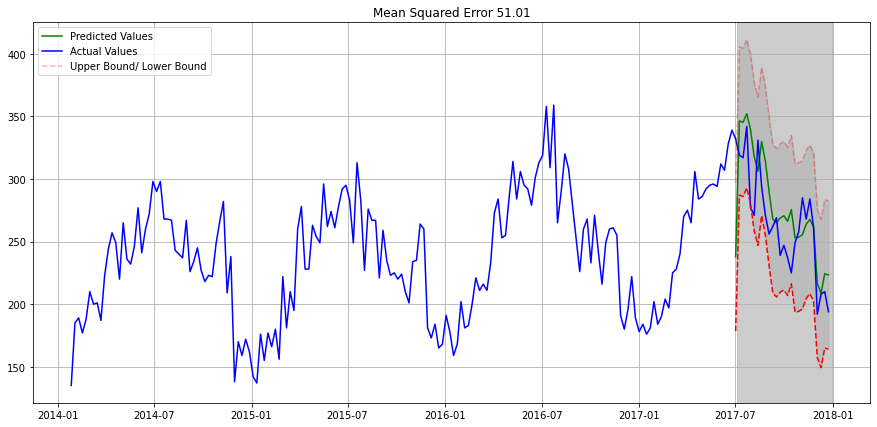

In [ ]:
lr = lr_model()

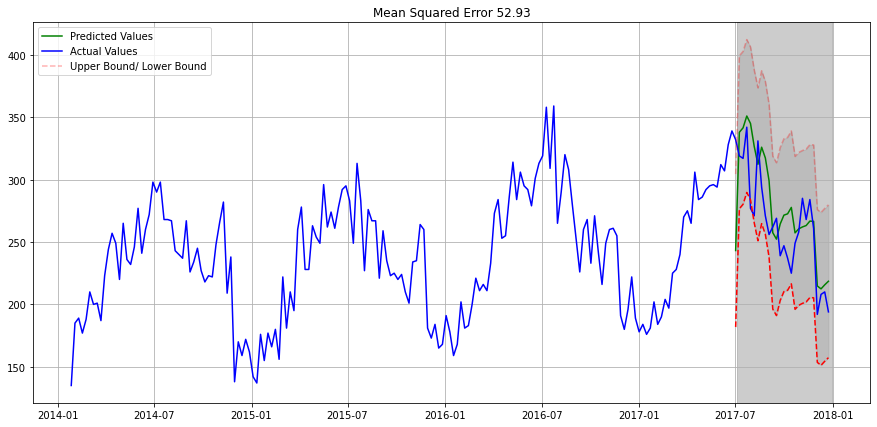

In [ ]:
lr = lr_model(info_level = 3)

XGBOOST MODEL 

In [ ]:
def XGBoost_model(info_level = 2, test_size = 180, scaling_metric = 1, plot_intervals = True, plot_anomalies = False, scale = 1.25):

    if info_level == 1:
        data_df = store_item_sale_TS_1.copy()
    if info_level == 2:
        data_df = store_item_sale_TS_2.copy()
    if info_level == 3:
        data_df = store_item_sale_TS_3.copy()
    
    # First we get the data in the required format
    data_df = data_df.dropna()
    data_df_y = data_df['sales']
    data_df_X = data_df.drop(['sales'], axis = 1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(data_df_X, data_df_y, test_size = test_size)
    
    # Then we scale the data
    if scaling_metric == 1:
        X_train_scaled, X_test_scaled = standard_scaler(X_train, X_test)
    if scaling_metric == 2:
        X_train_scaled, X_test_scaled = minmax_scaler(X_train, X_test)
    
    # We now initialize the model and train it
    xgb = XGBRegressor()
    xgb.fit(X_train_scaled, y_train)
    prediction = xgb.predict(X_test_scaled)
    #display(prediction)
    
    
    # We are now gonna plot the results along with coefficient scores
    
    predicted_df = pd.DataFrame(prediction, columns = ['sales'])
    predicted_df.index = X_test.index
    # Total error
    error_pred = float(mean_squared_error(data_df['sales'][0-test_size:],predicted_df['sales']))
    
    plt.figure(figsize = (15,7))
    plt.title("Mean Squared Error {0:.2f}".format(error_pred))
    agg_predicted = predicted_df.resample('W', label = 'left').sum()
    agg_actual = data_df.resample('W', label = 'left').sum()
    plt.plot(agg_predicted, color = "g", label = "Predicted Values")
    plt.plot(agg_actual['sales'], color = "b", label = "Actual Values")
    
    if plot_intervals:
        deviation = []
        lower_bound = []
        upper_bound = []
        agg_actual_reindexed = agg_actual.set_index(pd.Index(range(0,len(agg_actual))))
        agg_predicted_reindexed = agg_predicted.set_index(pd.Index(range(0,len(agg_predicted))))
        deviation = np.std((agg_actual_reindexed.iloc[(0-len(agg_predicted)):, 0].values, agg_predicted_reindexed['sales'].values)) 
        lower_bound = np.array(agg_predicted['sales'].values) - ((error_pred/10) + scale*deviation)
        upper_bound = np.array(agg_predicted['sales'].values) + ((error_pred/10) + scale*deviation)
        LowerBound_aggregated = pd.DataFrame(lower_bound, columns = ['sales'])
        LowerBound_aggregated.index = agg_predicted.index
        UpperBound_aggregated = pd.DataFrame(upper_bound, columns = ['sales'])
        UpperBound_aggregated.index = agg_predicted.index
        plt.plot(UpperBound_aggregated['sales'], "r--", alpha = 0.3, label = "Upper Bound/ Lower Bound")
        plt.plot(LowerBound_aggregated['sales'], "r--")
        plt.fill_between(x = agg_predicted.index, y1 = UpperBound_aggregated.values.ravel(), y2 = LowerBound_aggregated.values.ravel(), alpha = 0.2, color = "grey")
        plt.axvspan(X_test.index[0], X_test.index[-1], alpha = 0.4, color = "grey")
        
    # I still have to write the code for anomalies
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.show()
    
    return xgb

[07:04:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


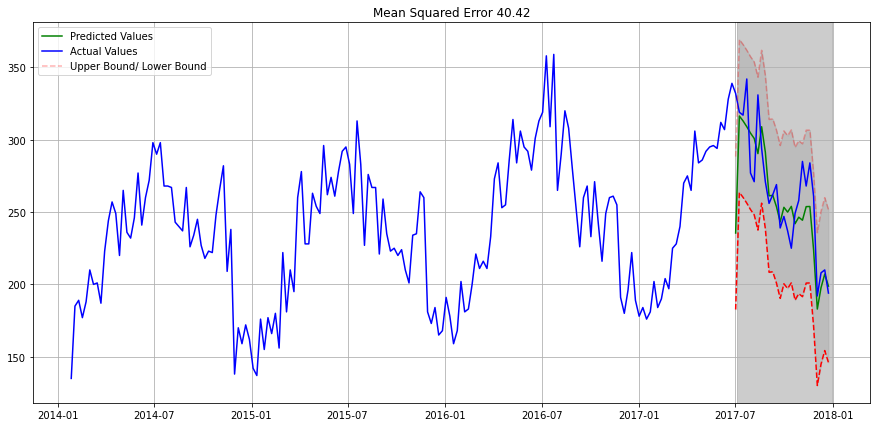

In [ ]:
xgb = XGBoost_model()

[06:03:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


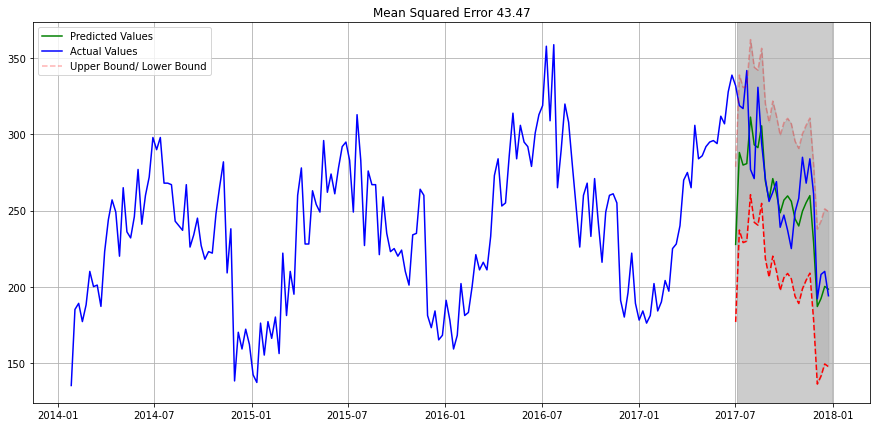

In [ ]:
xgb = XGBoost_model(info_level = 3)